In [330]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
from keras.losses import MSE
from keras.backend import mean, print_tensor

In [331]:
DATA_PATH = './1950-2018_torn_preprocessed.csv'
LEARNING_RATE = 0.001
EPOCHS = 15
BATCH_SIZE = 256

In [332]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

# Data imported is preprocessed
### check out the notebook Feature Engineering to see what was done

In [333]:
#### load data
data = pd.read_csv(DATA_PATH, usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
data.tail()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
64709,3,22,1,0,0,7000.0,0.0,30.1302,-92.3645,30.1321,-92.3547,0.60,25,6.214328,2.683444
64710,3,28,0,0,0,15000.0,0.0,32.6431,-90.4509,32.6427,-90.4288,1.29,100,6.214328,2.744530
64711,3,21,1,0,0,55000.0,0.0,36.8900,-87.9870,36.8915,-87.9734,0.76,125,6.283185,3.294309
64712,3,18,1,0,0,50000.0,0.0,38.1813,-86.8863,38.2006,-86.8585,2.01,50,6.283185,3.591015
64713,3,18,1,0,0,20000.0,0.0,38.0935,-86.0869,38.1000,-86.0470,2.20,140,6.283185,3.830998


### Split the data for training and testing
#### 90% training and 10% test
Training data will be further split into training and validation

In [334]:
train, test = train_test_split(data, test_size=0.10, random_state=1)

In [335]:
test.tail()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
31810,3,20,0,0,0,0.00,0.0,37.70,-100.17,0.00,0.00,0.1,10,3.081343,4.756022
44260,3,47,1,0,0,0.13,0.0,36.38,-84.45,36.40,-84.38,4.2,50,5.405261,4.668756
23696,3,24,3,0,0,4.00,0.0,39.70,-77.25,39.72,-77.20,2.0,37,2.444417,4.472406
35556,3,12,0,0,0,4.00,0.0,29.07,-81.05,0.00,0.00,0.1,10,2.926415,5.183628
34010,3,48,2,0,0,4.00,0.0,30.05,-96.42,30.08,-96.38,3.0,50,2.289489,3.468842


## Since this is a multiple output model we will be using two neural nets so we can have two seperate loss functions
One for Ending Latitude(elat) and another for Ending Longitude(elon)

# Longitude

In [336]:
train_lon = train
test_lon = test.drop(['elat'], axis=1)
#test_lon_labels = test_lon['elon'].values
test_lon_numpy = test_lon.to_numpy()
test_lon_numpy[:, 9]

array([-93.2 ,   0.  ,   0.  , ..., -77.2 ,   0.  , -96.38])

## Split the training data into training and validation set
### 80% training and 20% validation

In [337]:
train_lon, validation_lon = train_test_split(train_lon, test_size=0.20, random_state=1)
train_lon.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
22029,3,20,1,0,0,0.000,0.0,39.05,-99.88,0.00,0.00,0.50,17,3.442841,5.497787
52758,3,28,0,0,0,0.005,0.0,31.78,-89.10,31.79,-89.10,0.73,25,4.234695,2.177298
5614,3,29,2,0,0,5.000,0.0,36.62,-93.38,36.72,-93.12,16.30,50,1.222209,4.712389
13669,3,48,1,0,0,0.000,0.0,36.07,-102.55,0.00,0.00,0.10,10,2.255061,4.297873
12389,3,42,1,5,0,6.000,0.0,40.68,-80.33,40.68,-80.28,1.30,200,4.234695,4.830199


### Drop the predictor variables from the training and validation data
 train_df and validation_df look very similar but had to do it twice, so after splitting instead of before training and validation split is because there is a random_state to the data split and thus would lose information on what output value belongs to what row of data

In [338]:
train_lon_labels = train_lon['elon'].values
validation_lon_labels = validation_lon['elon'].values
train_lon_df = train_lon.drop(['elon'], axis=1)
validation_lon_df = validation_lon.drop(['elon'], axis=1)
validation_lon_df.head() 

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,len,wid,day_rad,time_rad
20227,3,8,0,0,0,2.00,0.0,39.38,-104.77,0.0,1.0,50,3.408413,4.516039
48658,3,28,0,0,0,0.01,0.0,33.70,-90.67,33.7,1.0,100,4.596193,4.341507
13352,3,25,1,0,0,3.00,0.0,42.47,-72.00,0.0,0.1,27,5.353618,2.356194
25546,3,27,0,0,0,0.00,0.0,48.60,-94.80,0.0,0.2,10,2.737059,3.015056
1171,3,37,1,0,0,4.00,0.0,35.20,-80.00,35.3,16.6,27,0.895139,2.574361


In [339]:
test_lon.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elon,len,wid,day_rad,time_rad
41332,3,22,1,5,0,0.1,0.0,30.0800,-93.2000,-93.2000,5.00,20,1.618135,1.090831
11575,3,55,1,0,0,5.0,0.0,42.7000,-89.0000,0.0000,0.50,100,3.046915,4.537856
17521,3,42,0,0,0,3.0,0.0,40.4300,-79.9800,0.0000,0.10,10,1.996848,3.381575
44752,3,47,2,10,0,50.0,0.0,36.0000,-89.4200,-89.2700,15.00,200,2.134562,5.759587
57819,3,12,0,0,0,0.0,0.0,29.0348,-82.7569,-82.7168,2.84,200,2.582131,3.198316


Scale the data using scikitlearn scaler

In [340]:
# Scale Data
scaler_lon = preprocessing.MinMaxScaler()
train_lon_df_scaled = scaler_lon.fit_transform(train_lon_df)
validation_lon_df_scaled = scaler_lon.transform(validation_lon_df)
test_lon_scaled = scaler_lon.transform(test_lon)
test_lon_labels_scaled = test_lon_scaled[:, 9] # test labels after scaling occurs
test_lon_labels_scaled

/Users/Vineeth/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([-1.52736808,  0.        ,  0.        , ..., -1.26515896,
        0.        , -1.57948214])

In [341]:
test_lon_scaled.shape

(6472, 14)

## Initialize feed forward neural network for predicting ending longitude

In [351]:
model_lon = Sequential()
model_lon.add(Dense(256, activation='relu', input_dim=train_lon_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model_lon.add(BatchNormalization())
model_lon.add(Dense(128, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(64, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(32, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(8, activation='relu'))
model_lon.add(BatchNormalization())
model_lon.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model_lon.compile(loss='mse', optimizer=adam, metrics=['mae'])

In [352]:
model_lon.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 256)               3840      
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
dense_92 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_77 (Batc (None, 128)               512       
_________________________________________________________________
dense_93 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_78 (Batc (None, 64)                256       
_________________________________________________________________
dense_94 (Dense)             (None, 32)                2080      
__________

In [353]:
trained_lon = model_lon.fit(x=train_lon_df_scaled, y=train_lon_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_lon_df_scaled, validation_lon_labels), 
                    shuffle=True)

Train on 46593 samples, validate on 11649 samples
Epoch 1/15
46593/46593 [==============================] - 10s 205us/step - loss: 4597.7219 - mean_absolute_error: 54.0573 - val_loss: 4054.7919 - val_mean_absolute_error: 51.5037
Epoch 2/15
46593/46593 [==============================] - 3s 63us/step - loss: 4127.3031 - mean_absolute_error: 52.3459 - val_loss: 3439.1165 - val_mean_absolute_error: 48.5883
Epoch 3/15
46593/46593 [==============================] - 3s 59us/step - loss: 3574.1279 - mean_absolute_error: 49.7648 - val_loss: 2950.7155 - val_mean_absolute_error: 46.0707
Epoch 4/15
46593/46593 [==============================] - 3s 58us/step - loss: 2946.8145 - mean_absolute_error: 46.3293 - val_loss: 2464.4627 - val_mean_absolute_error: 43.2499
Epoch 5/15
46593/46593 [==============================] - 3s 59us/step - loss: 2311.5383 - mean_absolute_error: 42.2086 - val_loss: 1821.3886 - val_mean_absolute_error: 38.4137
Epoch 6/15
46593/46593 [==============================] - 3s 59

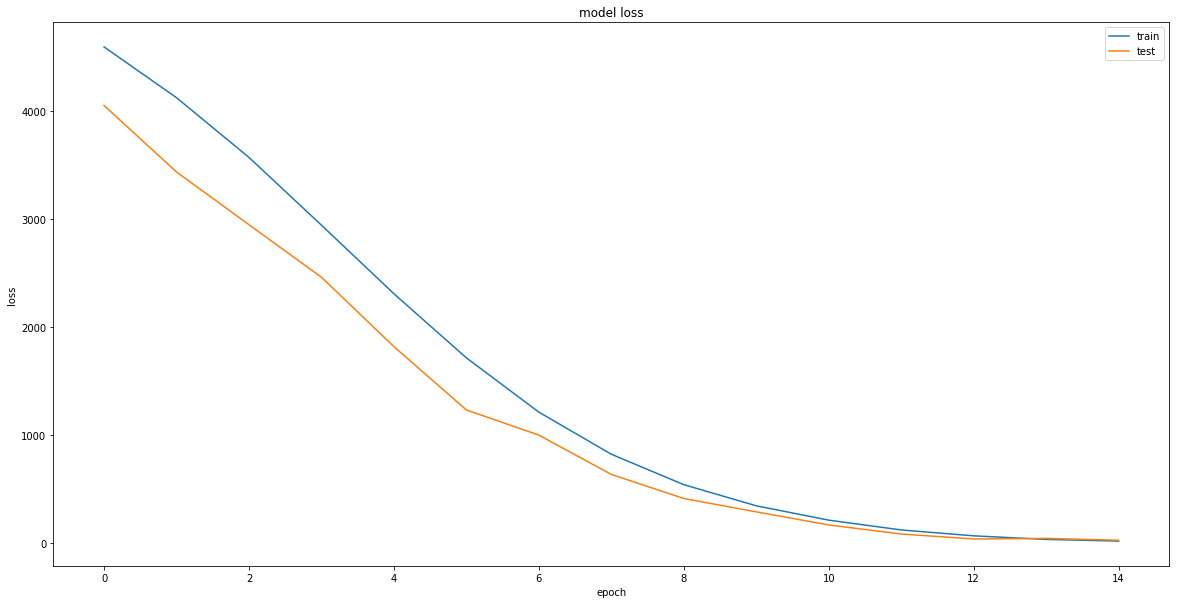

In [354]:
plot_loss_accuracy(trained_lon)

#### Model is starting to over fit around the 10th epoch

In [355]:
prediction_lon = model_lon.predict(test_lon_scaled, batch_size=128, verbose=1)

6472/6472 [==============================] - 4s 555us/step


In [356]:
test_lon['predicted_elon'] =  prediction_lon
test_lon.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elon,len,wid,day_rad,time_rad,predicted_elon
41332,3,22,1,5,0,0.1,0.0,30.0800,-93.2000,-93.2000,5.00,20,1.618135,1.090831,155.081879
11575,3,55,1,0,0,5.0,0.0,42.7000,-89.0000,0.0000,0.50,100,3.046915,4.537856,2.351273
17521,3,42,0,0,0,3.0,0.0,40.4300,-79.9800,0.0000,0.10,10,1.996848,3.381575,2.492471
44752,3,47,2,10,0,50.0,0.0,36.0000,-89.4200,-89.2700,15.00,200,2.134562,5.759587,132.462585
57819,3,12,0,0,0,0.0,0.0,29.0348,-82.7569,-82.7168,2.84,200,2.582131,3.198316,125.191498


#### This shows the percentage of predicted outputs that are different than actual value by more than 1

In [357]:
total = len(test_lon)
correct = 0
difference_dict = {}
for index in test_lon.index:
    difference_dict[index] = abs(test_lon['elon'][index] - test_lon['predicted_elon'][index])

count = 0
for key, value in difference_dict.items():
    if value <= 1:
        count += 1
count/total

0.00015451174289245981

### Scale the predictions so that its easier to compare with scaled test labels

In [306]:
prediction_lon = prediction_lon
test_scaler_lon = preprocessing.MinMaxScaler()
prediction_lon = test_scaler_lon.fit_transform(prediction_lon)

In [307]:
lon_errors = np.abs(np.subtract(test_lon_labels_scaled, prediction_lon.flatten()))

In [308]:
longitude_results = pd.DataFrame({'Longitude Test Labels':test_lon_labels_scaled, 'Predictions': prediction_lon.flatten(), 'Errors': lon_errors})
longitude_results.head()

,Longitude Test Labels,Predictions,Errors
0,-1.527368,0.509463,2.036831
1,0.000000,0.456026,0.456026
2,0.000000,0.455422,0.455422
3,-1.462963,0.568035,2.030998
4,-1.355569,0.392071,1.747640


#### Even though errors seem small they are in term of coordinates and they are scaled. So the model is not very accurate on test data
Based on how wild the starting value of loss function is we think that building this model from scratch is not helping. So it would be better to use transfer learning on a model that is already decent at data such as geocoordinates.

# Latitude

In [309]:
train_lat = train
test_lat = test.drop(['elon'], axis=1)
test_lat_labels = test_lat['elat'].values
test_lat_numpy = test_lat.to_numpy()
test_lat_numpy[:, 9]

array([ 30.07,   0.  ,   0.  , ...,  39.72,   0.  ,  30.08])

## Again split the training data into training and validation set
### 80% training and 20% validation

In [310]:
train_lat, validation_lat = train_test_split(train_lat, test_size=0.20, random_state=1)
train_lat.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,day_rad,time_rad
22029,3,20,1,0,0,0.000,0.0,39.05,-99.88,0.00,0.00,0.50,17,3.442841,5.497787
52758,3,28,0,0,0,0.005,0.0,31.78,-89.10,31.79,-89.10,0.73,25,4.234695,2.177298
5614,3,29,2,0,0,5.000,0.0,36.62,-93.38,36.72,-93.12,16.30,50,1.222209,4.712389
13669,3,48,1,0,0,0.000,0.0,36.07,-102.55,0.00,0.00,0.10,10,2.255061,4.297873
12389,3,42,1,5,0,6.000,0.0,40.68,-80.33,40.68,-80.28,1.30,200,4.234695,4.830199


### Drop the predictor variables from the training and validation data

In [311]:
train_lat_labels = train_lon['elat'].values
validation_lat_labels = validation_lat['elat'].values
train_lat_df = train_lat.drop(['elat'], axis=1)
validation_lat_df = validation_lat.drop(['elat'], axis=1)
validation_lat_df.head() 

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elon,len,wid,day_rad,time_rad
20227,3,8,0,0,0,2.00,0.0,39.38,-104.77,0.00,1.0,50,3.408413,4.516039
48658,3,28,0,0,0,0.01,0.0,33.70,-90.67,-90.67,1.0,100,4.596193,4.341507
13352,3,25,1,0,0,3.00,0.0,42.47,-72.00,0.00,0.1,27,5.353618,2.356194
25546,3,27,0,0,0,0.00,0.0,48.60,-94.80,0.00,0.2,10,2.737059,3.015056
1171,3,37,1,0,0,4.00,0.0,35.20,-80.00,-79.73,16.6,27,0.895139,2.574361


In [312]:
test_lat.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,len,wid,day_rad,time_rad
41332,3,22,1,5,0,0.1,0.0,30.0800,-93.2000,30.0700,5.00,20,1.618135,1.090831
11575,3,55,1,0,0,5.0,0.0,42.7000,-89.0000,0.0000,0.50,100,3.046915,4.537856
17521,3,42,0,0,0,3.0,0.0,40.4300,-79.9800,0.0000,0.10,10,1.996848,3.381575
44752,3,47,2,10,0,50.0,0.0,36.0000,-89.4200,36.1200,15.00,200,2.134562,5.759587
57819,3,12,0,0,0,0.0,0.0,29.0348,-82.7569,29.0561,2.84,200,2.582131,3.198316


#### Scale the data

In [313]:
scaler_lat = preprocessing.MinMaxScaler()
train_lat_df_scaled = scaler_lat.fit_transform(train_lat_df)
validation_lat_df_scaled = scaler_lat.transform(validation_lat_df)
test_lat_scaled = scaler_lat.transform(test_lat)
test_lat_labels_scaled = test_lat_scaled[:, 9] # test labels after scaling occurs
test_lat_labels_scaled

/Users/Vineeth/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([ 1.18388063,  1.        ,  1.        , ...,  1.24289121,
        1.        ,  1.18394178])

## Initialize feed forward neural network for predicting ending latitude

In [358]:
model_lat = Sequential()
model_lat.add(Dense(256, activation='relu', input_dim=train_lat_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))
model_lat.add(BatchNormalization())
model_lat.add(Dense(128, activation='relu'))
model_lat.add(BatchNormalization())
model_lat.add(Dense(64, activation='relu'))
model_lat.add(BatchNormalization())
model_lat.add(Dense(32, activation='relu'))
model_lat.add(BatchNormalization())
model_lat.add(Dense(8, activation='relu'))
model_lat.add(BatchNormalization())
model_lat.add(Dense(1))

adam = optimizers.adam(lr=LEARNING_RATE)
model_lat.compile(loss='mse', optimizer=adam, metrics=['mae'])

In [359]:
model_lat.summary() # same as one for longitude

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 256)               3840      
_________________________________________________________________
batch_normalization_81 (Batc (None, 256)               1024      
_________________________________________________________________
dense_98 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_82 (Batc (None, 128)               512       
_________________________________________________________________
dense_99 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_83 (Batc (None, 64)                256       
_________________________________________________________________
dense_100 (Dense)            (None, 32)                2080      
__________

In [360]:
trained_lat = model_lat.fit(x=train_lat_df_scaled, y=train_lat_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(validation_lat_df_scaled, validation_lat_labels), 
                    shuffle=True)

Train on 46593 samples, validate on 11649 samples
Epoch 1/15
46593/46593 [==============================] - 10s 220us/step - loss: 682.7217 - mean_absolute_error: 21.5863 - val_loss: 520.6581 - val_mean_absolute_error: 17.9759
Epoch 2/15
46593/46593 [==============================] - 3s 58us/step - loss: 532.8343 - mean_absolute_error: 20.0464 - val_loss: 456.3409 - val_mean_absolute_error: 19.0170
Epoch 3/15
46593/46593 [==============================] - 3s 62us/step - loss: 380.5799 - mean_absolute_error: 17.7880 - val_loss: 313.5957 - val_mean_absolute_error: 16.6785
Epoch 4/15
46593/46593 [==============================] - 3s 59us/step - loss: 246.1113 - mean_absolute_error: 14.9897 - val_loss: 180.1101 - val_mean_absolute_error: 13.1892
Epoch 5/15
46593/46593 [==============================] - 3s 58us/step - loss: 149.3340 - mean_absolute_error: 12.0153 - val_loss: 127.6087 - val_mean_absolute_error: 11.2696
Epoch 6/15
46593/46593 [==============================] - 3s 59us/step - 

#### Notice how large the discrepancy between the two model loss functions starting values is. We also noticed this on reruns of the same model

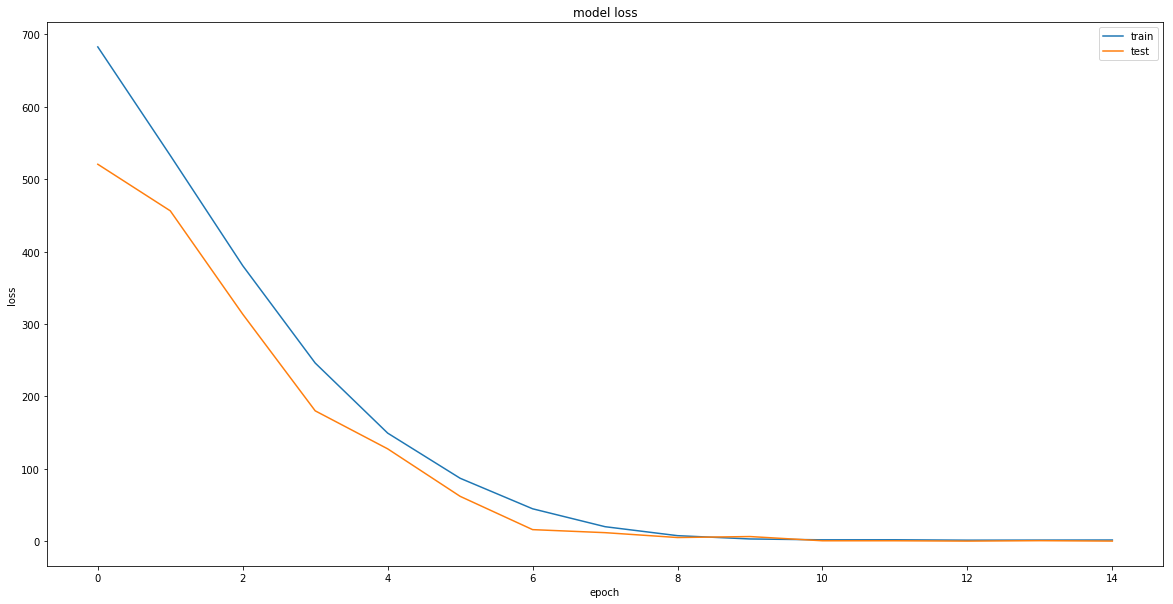

In [361]:
plot_loss_accuracy(trained_lat)

### This one starts to overfit before the 10th epoch

In [362]:
prediction_lat = model_lat.predict(test_lat_scaled, batch_size=128, verbose=1)

6472/6472 [==============================] - 4s 620us/step


In [363]:
test_lat['predicted_elat'] =  prediction_lat
test_lat.head()

,tz,stf,mag,inj,fat,loss,closs,slat,slon,elat,len,wid,day_rad,time_rad,predicted_elat
41332,3,22,1,5,0,0.1,0.0,30.0800,-93.2000,30.0700,5.00,20,1.618135,1.090831,1.372277
11575,3,55,1,0,0,5.0,0.0,42.7000,-89.0000,0.0000,0.50,100,3.046915,4.537856,-0.161029
17521,3,42,0,0,0,3.0,0.0,40.4300,-79.9800,0.0000,0.10,10,1.996848,3.381575,-0.161273
44752,3,47,2,10,0,50.0,0.0,36.0000,-89.4200,36.1200,15.00,200,2.134562,5.759587,1.891341
57819,3,12,0,0,0,0.0,0.0,29.0348,-82.7569,29.0561,2.84,200,2.582131,3.198316,1.340149


#### This shows the percentage of predicted outputs that are different than actual value by more than 1

In [364]:
total = len(test_lat)
correct = 0
difference_dict = {}
for index in test_lat.index:
    difference_dict[index] = abs(test_lat['elat'][index] - test_lat['predicted_elat'][index])

count = 0
for key, value in difference_dict.items():
    if value <= 1:
        count += 1
count/total

0.4127008652657602

### Scale the predictions so that its easier to compare with scaled test labels

In [327]:
prediction_lat = prediction_lat
test_scaler_lat = preprocessing.MinMaxScaler()
prediction_lat = test_scaler_lat.fit_transform(prediction_lat)

In [328]:
lat_errors = np.abs(np.subtract(test_lat_labels_scaled, prediction_lat.flatten()))

In [329]:
latitude_results = pd.DataFrame({'Longitude Test Labels':test_lat_labels_scaled, 'Predictions': prediction_lat.flatten(), 'Errors': lat_errors})
latitude_results.tail()

,Longitude Test Labels,Predictions,Errors
6467,1.000000,0.043327,0.956673
6468,1.222589,0.190980,1.031609
6469,1.242891,0.183757,1.059135
6470,1.000000,0.044117,0.955883
6471,1.183942,0.149132,1.034810


### This model is slightly better than the longitude model probably because there are no negative values. But it is still very bad at predicting the ending values